<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно, если придумать как переводить текст в матрицу(сверточные сети работают с матрицами). Например, при помощи tf-idf_vectorizer. Правда в данном случае не ясно как интерпитировать свертку слоя.
Чтобы избежать проблемы можно подавать матрицу разбитую на куски одинакового заранее заданного размера. В случае с tf-idf такой проблемы нет, т.к. каждый текст переходит в вектор размерности мощности словаря(словарь формируется на стадии обучения) => все векторы одного размера и вход имеет одинаковый формат.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

LSTM лучше чем обычная RNN, потому что у него есть контролер памяти, т.е. LSTM может проносить в себе какую-то информацию на много шагов вперед(в отличии от RNN) и при этом не обязательно использует эту информацию для вычисления текущего выхода(например, в выходе была открывающая скобка. эту инфу можно на первых этапах не использовать и при помощи forget gate она не будет поступать из памяти в скрытое состояние какое-то время, пока не будет необходимости закрыть скобку).

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{n-1}}\cdots\frac{d c_{k+1}}{d c_{k}}$. Если значение элементов больше $1$, то градиент взрывается. В противном случае - затухает. Данное явление контролируется при помощи forget gate.

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

TBPTT борется с проблемой затухания градиентов на более отдаленных слоях(ближе к input).

**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Image Captioning(сначала прогоняем картинку через сверточную сеть без нескольких последних слоев, чтобы на выходе после умножения на матрицу получить вектор, который будут служить нулевым скрытым состоянием для RNN, которая далее генерирует описание).
Video Captioning(примерно также, только сначала прогоняем через CNN кадры, после чего подаем их на вход RNN1 и самое последнее скрытое состояние из этой RNN подаем как первое скрытое состояние для следующей RNN, которая уже генерирует подписи).

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Если размер будет недостаточным, то мы будем терять информацию, содержащуюся в тексте, а если большим, то переобучимся + будем хранить лишние параметры.

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline.

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
#!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
#!tar -xvzf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 531 ms, sys: 541 ms, total: 1.07 s
Wall time: 1.18 s


In [3]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print('\n\n')
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
# Build a Vocabulary
from collections import defaultdict

word_counts = defaultdict(int)
for img in captions:
    for cap_img in img:
        for word in cap_img:
            word_counts[word] += 1

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [7]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   36,
        1836,   14,   -1,   -1],
       [   3,  171,  172,  183, 1405,   43, 1836,   36,  186, 1381,  588,
          14,   -1,   -1,   -1],
       [   3,    4,  206,   32,   50,  588,   21,  171,   24, 3575,   65,
          27,  605,  353,   14],
       [   3,    4,    5,   75,  449,    9,    4,    5,  102,   14,   -1,
          -1,   -1,   -1,   -1],
       [   3,   64,  322,  206,   32,   50,  588,   21,  171,  172,   65,
          27, 3576,   14,   -1]], dtype=int32)

### Mah Neural Network

In [8]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [9]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [10]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [11]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words, input_size=n_tokens, output_size=EMBED_SIZE)

In [12]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
#l_image_features_small = <Apply Dropout Layer to regularise your Net>
#l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = lasagne.layers.DropoutLayer(l_image_features, p=0.5)
l_image_features_small = lasagne.layers.DenseLayer(l_image_features_small, num_units=LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [13]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=10e8)

In [14]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer, UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print("broadcasted decoder shape = ", broadcast_decoder_ticks.output_shape)

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print("output shape = ", predicted_probabilities.output_shape)

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [15]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = (output_mask * loss).sum() / output_mask.sum()

In [16]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights)

In [17]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

/usr/local/lib/python3.6/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [18]:
captions = np.array(captions)

In [19]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = [x for x in map(choice, captions_for_batch_images)]
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [20]:
generate_batch(img_codes,captions, 3)

(array([[-1.77154207, -0.33890149, -2.12783122, ..., -2.13732934,
         -0.56898665, -0.96526814],
        [-2.44050789,  0.14260525,  0.47827166, ..., -4.04701424,
         -0.1078952 , -1.54173958],
        [ 2.52425194,  4.72401285,  1.50932062, ..., -4.3065629 ,
          1.71172845,  3.36792088]], dtype=float32),
 array([[   3,    4,  704,  414,   83,    4,  228,  123,    9,    4,   13,
           14,   -1,   -1],
        [   3, 2352, 7044,   27, 2332,  375,    4,   40,   65,   27,    4,
         2332, 3946,   14],
        [   3,    4,    5, 7294, 2473,  237, 2145,    6,    4, 2782,   14,
           -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [23]:
batch_size = 128 #adjust me
n_epochs   = 10 #adjust me
n_batches_per_epoch = 128 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [24]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 0, train loss: 5.153484274044289, val loss: 4.78493339618158


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.492400458853292, val loss: 4.274060675951192


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.069405851893462, val loss: 3.907434599814651


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 3, train loss: 3.849625444478571, val loss: 3.803667558120999


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.684128461097415, val loss: 3.5626284173260103


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.53998855928997, val loss: 3.51395689722179


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.4314261340932903, val loss: 3.433110256994067


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.346939911524443, val loss: 3.2357629146385785


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.259942445745858, val loss: 3.2529511854902977


100%|██████████| 128/128 [06:36<00:00,  3.59s/it]



Epoch: 9, train loss: 3.225078951660913, val loss: 3.2109093566222624
Finish :)


In [31]:
from tqdm import tqdm

for epoch in range(n_epochs, 2*n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")



  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.156530409958117, val loss: 3.114760708591583


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.1166095234026523, val loss: 3.0417585510756466


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.0760274035138386, val loss: 3.173078180250313


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.0564564732102126, val loss: 3.0614436374249197


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.032658978460896, val loss: 3.1219376176354205


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 15, train loss: 2.980155779221271, val loss: 3.0186861540925523


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 16, train loss: 2.9688778753175478, val loss: 2.99629748149225


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 17, train loss: 2.9527846389097028, val loss: 3.0040555816982293


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 18, train loss: 2.912859178046987, val loss: 2.9692087674507235


100%|██████████| 128/128 [06:18<00:00,  2.68s/it]



Epoch: 19, train loss: 2.9087118594813752, val loss: 2.9190733381081135
Finish :)


In [37]:
from tqdm import tqdm

for epoch in range(2*n_epochs, 3*n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")



  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.8826683994786286, val loss: 2.881691590936737


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.885795538619058, val loss: 2.8346991445837553


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 22, train loss: 2.862236977318551, val loss: 2.859080724359184


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.8414902035307636, val loss: 2.807192442235317


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 24, train loss: 2.841182029233138, val loss: 2.8443202646720787


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 25, train loss: 2.823825828863471, val loss: 2.9013127445211224


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 26, train loss: 2.806813748749906, val loss: 2.8630003647120037


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 27, train loss: 2.7862136907949213, val loss: 2.7909424237244917


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.7715778330931444, val loss: 2.7549013448668886


100%|██████████| 128/128 [06:08<00:00,  2.55s/it]



Epoch: 29, train loss: 2.769669359608763, val loss: 2.6957490179180423
Finish :)


In [43]:
from tqdm import tqdm

def train(beg_epoch, end_epoch):
    batch_size = 128 #adjust me
    n_epochs   = 10 #adjust me
    n_batches_per_epoch = 128 #adjust me
    n_validation_batches = 5 #how many batches are used for validation after each epoch
    
    for epoch in range(beg_epoch, end_epoch):
        train_loss=0
        for _ in tqdm(range(n_batches_per_epoch)):
            train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
        train_loss /= n_batches_per_epoch

        val_loss=0
        for _ in range(n_validation_batches):
            val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
        val_loss /= n_validation_batches

        print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    print("Finish :)")

def apply():
    for i in range(10):
        print(' '.join(generate_caption(img,t=1.)[1:-1]))

In [44]:
step = 10
for epoch in range(30, 100, step):
    train(epoch, epoch + step)
    apply()

  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.770310943459508, val loss: 2.73548197574929


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.7517917891590056, val loss: 2.7381071394666416


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.7371674394484145, val loss: 2.720503415865141


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.747261812440379, val loss: 2.765482003675104


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.727897748649614, val loss: 2.7164437953475917


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.7143881520946405, val loss: 2.706999213363965


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.6952312744797204, val loss: 2.680155587127598


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.705904294156313, val loss: 2.7245201201223876


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.711392784336211, val loss: 2.618736194436974


100%|██████████| 128/128 [05:49<00:00,  3.06s/it]



Epoch: 39, train loss: 2.688989992967284, val loss: 2.672635575733112
Finish :)
child feeds a cat eating a bath light
an old cute black small looking likely shows the front drive
orange family sitting on top of a white bear his dried
a black and white photo of a large rodent eating a womans hand
two brown bears and a person sitting on a table
a gray and brown bird is notice a group of little striped cloth
a large white kitten is curled up at a row of day
full #UNK# animals is seen from the day
a white dog is drinking from a fuzzy liquid


  0%|          | 0/128 [00:00<?, ?it/s]

a little girl standing in front of a bear looks at a camera


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.683111078964054, val loss: 2.7058215649957855


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.679371625708129, val loss: 2.6858924931290113


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.6569621877032974, val loss: 2.6319903291256224


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.661556156295074, val loss: 2.678963251034196


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.658584940679941, val loss: 2.65161881795282


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.6736289269854177, val loss: 2.633102573178141


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.638019437266701, val loss: 2.6821872395264963


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.642896293415987, val loss: 2.630451226263787


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.6356256851670694, val loss: 2.6674682906296288


100%|██████████| 128/128 [06:02<00:00,  2.97s/it]



Epoch: 49, train loss: 2.6405851142428087, val loss: 2.6505697907192562
Finish :)
dog holding a view a window while a cat holding bananas in the other of the head of the movie
stuff and a few puppies one with two hair
two white small brown animals with pink frosting
two small children with woman looking at his hat
a white and white woman in striped with white eyes
white woman checking an face of a brown toy and the other shopped animal colored
two white and a black and white next to some white are brown bears
older woman holding a mirror pointing a laptop
asian child sitting next to an animal in a garden


  0%|          | 0/128 [00:00<?, ?it/s]

a man looking into the camera look slightly off in her mouth


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.6136602739481076, val loss: 2.59663771368895


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.616466619336441, val loss: 2.6630631236466984


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.611988802337496, val loss: 2.5691357238248544


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.611409746392433, val loss: 2.6602012777279382


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.6137041076268606, val loss: 2.5548014933859142


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.5906281445203816, val loss: 2.560184084882441


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.6055661273138186, val loss: 2.610741752465443


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.586016440323131, val loss: 2.6227336373861894


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.5760109755382197, val loss: 2.590617742299231


100%|██████████| 128/128 [06:52<00:00,  3.39s/it]



Epoch: 59, train loss: 2.583484117477189, val loss: 2.536232594229058
Finish :)
fancy grey and white picture of a food game
gray black and white photo of a bull grow with clusters of cloths
fluffy orange and white dog cats sitting on a blue table
white orange looking at the camera mouse and a laptop
large panda bear found into a bowl as a little girl is her
gray white face a grey and black cat standing around
small asian black dog holding up a white teddy bear
face many cats and a woman standing in a pot
beat up a for a little dog shuttle


  0%|          | 0/128 [00:00<?, ?it/s]

healthy animals leaning on a tray and a large furry dog


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.5949145637821007, val loss: 2.5591507231502577


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.5829868556671998, val loss: 2.6300454277968823


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.5650534605342266, val loss: 2.570675438606239


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.5579339098511964, val loss: 2.6343624754690635


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.5693219687591, val loss: 2.544463130262609


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.5644940552594804, val loss: 2.6571725392479033


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.577929856459254, val loss: 2.598461641281886


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.582644185007955, val loss: 2.567103620941603


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.550615556112994, val loss: 2.5910775315416505


100%|██████████| 128/128 [06:23<00:00,  3.27s/it]



Epoch: 69, train loss: 2.53810234020761, val loss: 2.550190205168674
Finish :)
woman and a woman are pointing at the camera
small dog holding up a book while looking into a window
black cat is sitting next to a large brown and black red green couch
large fluffy brown and black dog on a wicker chair
small brown and white dog sitting in a window
light a brown and white brown animal dressed in black paper and brown colored hair
black and silver white fluffy dog is sitting on the back of a car
small black and white photo of a male and white sofa feeding broccoli
three white brown haired brown and white images are outside of a kitchen


  0%|          | 0/128 [00:00<?, ?it/s]

lady in a band sitting next to a little girl with a cellphone


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.5357157937922823, val loss: 2.5046054110837828


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.544406472921727, val loss: 2.4610356433295704


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.5338259060618005, val loss: 2.490775745767536


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.5300755907707213, val loss: 2.528241066228231


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.512667755311827, val loss: 2.539650390060774


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.5264021544145843, val loss: 2.5319233978249533


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.5290097097178954, val loss: 2.5343241577563873


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.5271629189549776, val loss: 2.4714600260761537


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.5071922019631785, val loss: 2.530308236100992


100%|██████████| 128/128 [06:13<00:00,  3.40s/it]



Epoch: 79, train loss: 2.5167866856203607, val loss: 2.476914122709636
Finish :)
white woman holding a pink #UNK# stands in front of long hair
white orange and brown kitten are finds her food
white girl holding a multi colored curly hair and looking white head covered landscape
white dog looking for a camera are sitting at a table with flowers and standing on a table around with a decorative beef showing to the wall being hand in a hand wrapped around a red toy
black and white image of an old woman smiling and others at a white cabinet
man is sitting on a green green and white green umbrella as jars of most of them
a girl holding a funny puppy and a teddy bear
small girl holding a pink covered disc covered in their pink
man holds a pink on top with a cat


  0%|          | 0/128 [00:00<?, ?it/s]

a red and white cat taking a picture of a little girl


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.5161392887714156, val loss: 2.5509829300525717


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.5140721843281426, val loss: 2.566523093174007


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.5122741775634396, val loss: 2.512262300955611


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.520993854149054, val loss: 2.4460583271845944


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.514069852196482, val loss: 2.4574069832397654


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.5018315582185586, val loss: 2.482083382188999


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.4973923953782657, val loss: 2.534838116902823


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.4828072392900773, val loss: 2.4637417009592126


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.4976618563222273, val loss: 2.487731473074462


100%|██████████| 128/128 [06:16<00:00,  3.32s/it]



Epoch: 89, train loss: 2.4961506754218488, val loss: 2.513401403416866
Finish :)
five white and cat sleeping on a grass covered floor
black and white photo of a hamster is talking
fluffy brown and white man gives a camera in the middle of eating
two bears in broken around a black and white gray and red stuff
white and white black and red dog lying down under a green white cloth
woman holding two brown hair with her hair with a blue top on
empty green white and white cat is posed for a camera on their lap
and women playing in food next to a display that appear to be a tight #UNK# hold some stuffed animals
small child is holding a small child on her back and her ducks relaxes


  0%|          | 0/128 [00:00<?, ?it/s]

black and white photo showing a person dressed in a room doing a colorful sheep


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.483713212672006, val loss: 2.510427364051084


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.472367939572803, val loss: 2.47845801842463


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.4990332485298596, val loss: 2.424314928835098


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.4795546230520236, val loss: 2.428991991338878


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.4859337646037485, val loss: 2.480415217154158


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.4839969046030834, val loss: 2.5477445746507343


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.4779743384172237, val loss: 2.472127732228501


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.483487256876052, val loss: 2.4682570717618275


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.4762758301039565, val loss: 2.4768632901989385


100%|██████████| 128/128 [06:26<00:00,  2.88s/it]



Epoch: 99, train loss: 2.4677390654132587, val loss: 2.485567009331891
Finish :)
a black and white image of a girl holding a picture of a pink and blue umbrella
two white black and black double looking up cats on a bilingual scale
woman holding a white teddy bear in her mouth
white boy with her black hair and white bowtie and green #UNK#
small black and white photo of a potted brown and orange face
both of white children smiling and touching cute rabbits
white one smiling using a large child on the ground
child in a green top is holding a brown teddy bear
man looks on for a blue goatee looking pensive
black black and white photo shows a small child


In [ ]:
step = 5
for epoch in range(100, 200, step):
    train(epoch, epoch + step)
    apply()

  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 100, train loss: 2.464394468308978, val loss: 2.44363422698719


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 101, train loss: 2.469150435641503, val loss: 2.3825549347507717


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 102, train loss: 2.461641161026924, val loss: 2.439208518365813


  0%|          | 0/128 [00:00<?, ?it/s]


Epoch: 103, train loss: 2.4607445987830534, val loss: 2.463620392434111


100%|██████████| 128/128 [06:06<00:00,  2.92s/it]



Epoch: 104, train loss: 2.4530165027716744, val loss: 2.4354552157496876
Finish :)
woman kneeling down next to an animal picture
small girl with children playing in a red and white soccer shaves the other look on
black and white photograph of a man holding an alarm like pet look like a #UNK#
of small children are holding a laptop and a little girl on
small black and white cat lying down on a chair
#UNK# smiling and green black and white picture of a large pretty brown and white picture
orange
multi colored large furry furry black tabby cat eating
a bunch of people are sitting under a blue background


  0%|          | 0/128 [00:00<?, ?it/s]

black and white photo of a pair of black and white animal eat


 41%|████      | 52/128 [02:29<03:36,  2.84s/it]

### apply trained model

In [38]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl', 'rb'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


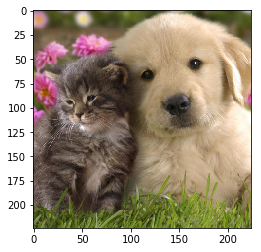

In [40]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [41]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [42]:
for i in range(10):
    print(' '.join(generate_caption(img,t=1.)[1:-1]))

a young man in striped santa shirt and kids holding a stuffed teddy bear
black stuffed bear standing in front of a boy
passengers seems to take off a plate of another woman
girl is playing in help of a picture
has blue stripes with a brown dog and measuring bottle staring
pink brown furry dog is presents close to some grass
two green cow standing next to a microwave
brown cat sitting in a black and white and white teddy bear
a little black bear with a big dolls on its head
the people are feeding in this picture


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 